This piece of work comes from many contributors with our team's extra work on it.
kudos to the following notebooks:
https://www.kaggle.com/kabure/almost-complete-feature-engineering-ieee-data
https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
https://www.kaggle.com/nroman/recursive-feature-elimination
https://www.kaggle.com/kyakovlev/ieee-lgbm-with-groupkfold-cv
https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm
https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499
https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again


In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

import gc
import os 


### This is the function to reduce data frame size by downgrade the numerical types if the numeical data is small enough

In [ ]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Now read the data into data frames 

In [ ]:
#df_trans = pd.read_csv('train_transaction.csv')
df_trans = pd.read_csv('train_transaction.csv',index_col='TransactionID')
df_test_trans = pd.read_csv('test_transaction.csv',index_col='TransactionID')

#record index of test datasets
test_trans_id = df_test_trans.index

#df_id = pd.read_csv('train_identity.csv')
df_id = pd.read_csv('train_identity.csv',index_col='TransactionID')
df_test_id = pd.read_csv('test_identity.csv',index_col='TransactionID')

sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')

### Here we define a id split function to split id data frame such that more specific information is put into seperate columns. Also, device_name is grouped into different groups. 

In [2]:
def id_split(dataframe):
    
    #expand = split and expand to seperate column
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]
    
    #very specifically group device brands to help making decision
    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    #make the device name that are less than 200 to be other
    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    
    #new column to record that this device has id
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

### Here I define some extra features to summarize some NA and 0's information for C, M, V, and id features. 

In [4]:

#C sum feature
df_trans["C_sum"] = df_trans.loc[:,'C1':'C14'].sum(axis = 1).astype(np.int8)
df_test_trans["C_sum"] = df_test_trans.loc[:,'C1':'C14'].sum(axis = 1).astype(np.int8)

    
##D1 - D15
df_trans['D_na'] =df_trans.loc[:,'D1':'D14'].isna().sum(axis=1).astype(np.int8)
df_test_trans['D_na'] =df_test_trans.loc[:,'D1':'D14'].isna().sum(axis=1).astype(np.int8)

    
##M1-9
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

df_trans['M_na'] = df_trans[i_cols].isna().sum(axis=1).astype(np.int8)
df_test_trans['M_na'] = df_test_trans[i_cols].isna().sum(axis=1).astype(np.int8)


    
##V_ features
df_trans['V_na'] =df_trans.loc[:,"V1":"V339"].isna().sum(axis=1).astype(np.int8)
df_test_trans['V_na'] =df_test_trans.loc[:,"V1":"V339"].isna().sum(axis=1).astype(np.int8)

##ids 
df_id['id_na'] = df_id.loc[:,"id_01":"id_38"].isna().sum(axis=1).astype(np.int8)
df_test_id['id_na'] = df_test_id.loc[:,"id_01":"id_38"].isna().sum(axis=1).astype(np.int8)




In [5]:
df_id = id_split(df_id)
df_test_id = id_split(df_test_id)

### Now we merge the transations and id data frames. Also, we created a new tot_na to count the total missing values. 

In [6]:

##do not need to include right_index
df_train = df_trans.merge(df_id, how='left', left_index=True,  on='TransactionID')
df_test = df_test_trans.merge(df_test_id, how='left', left_index=True, on='TransactionID')

#add total na for train and test data. 
df_train['tot_na'] = df_train.isna().sum(axis=1).astype(np.int8) 
df_test['tot_na'] = df_test.isna().sum(axis=1).astype(np.int8)

print(df_train.head())
print(df_test.head())


# y_train = df_train['isFraud'].copy()
del df_trans, df_id, df_test_trans, df_test_id
gc.collect()



df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
##Deal with missing data



               isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  ...  device_name  \
TransactionID                                    ...                
2987000        150.0    discover  142.0  credit  ...          NaN   
2987001        150.0  mastercard  102.0  credit  ...          NaN   
2987002        150.0        visa  166.0   debit  ...          NaN   
2987003        150.0  mastercard  117.0   debit  ...          NaN   
2987004        150

### Here features are selected based on some of the listed kernels at the beggining of this notebook.

In [8]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294','id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id','tot_na','C_sum','D_na','M_na','V_na','id_na']
print(len(useful_features))

272


In [9]:
cols_to_drop = [col for col in df_train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')
cols_to_drop.remove('TransactionDT')

In [10]:
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

### Interactions between numerical and categorical features 

In [11]:
#added card6 - debit credit
columns_a = ['TransactionAmt', 'id_02', 'D15']
columns_b = ['card1', 'card4', 'addr1','card6']

for col_a in columns_a:
    for col_b in columns_b:
        for df in [df_train, df_test]:
            df[f'{col_a}_to_mean_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('mean')
            df[f'{col_a}_to_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('std')

### Conversion and creation of time-related features and encoding for some single features and interaction features. Encoding types include: 
1. Label encoding 
2. Count or frequency encoding

In [12]:
# New feature - log of transaction amount.
df_train['TransactionAmt_Log'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt_Log'] = np.log(df_test['TransactionAmt'])

# New feature - decimal part of the transaction amount.
df_train['TransactionAmt_decimal'] = ((df_train['TransactionAmt'] - df_train['TransactionAmt'].astype(int)) * 1000).astype(int)
df_test['TransactionAmt_decimal'] = ((df_test['TransactionAmt'] - df_test['TransactionAmt'].astype(int)) * 1000).astype(int)

# New feature - day of week in which a transaction happened.
df_train['Transaction_day_of_week'] = np.floor((df_train['TransactionDT'] / (3600 * 24) - 1) % 7)
df_test['Transaction_day_of_week'] = np.floor((df_test['TransactionDT'] / (3600 * 24) - 1) % 7)

# New feature - hour of the day in which a transaction happened.
df_train['Transaction_hour'] = np.floor(df_train['TransactionDT'] / 3600) % 24
df_test['Transaction_hour'] = np.floor(df_test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    df_train[feature] = df_train[f1].astype(str) + '_' + df_train[f2].astype(str)
    df_test[feature] = df_test[f1].astype(str) + '_' + df_test[f2].astype(str)

    le = preprocessing.LabelEncoder()
    le.fit(list(df_train[feature].astype(str).values) + list(df_test[feature].astype(str).values))
    df_train[feature] = le.transform(list(df_train[feature].astype(str).values))
    df_test[feature] = le.transform(list(df_test[feature].astype(str).values))

# Encoding - count encoding for both df_train and df_test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_36']:
    df_train[feature + '_count_full'] = df_train[feature].map(pd.concat([df_train[feature], df_test[feature]], ignore_index=True).value_counts(dropna=False))
    df_test[feature + '_count_full'] = df_test[feature].map(pd.concat([df_train[feature], df_test[feature]], ignore_index=True).value_counts(dropna=False))

# Encoding - count encoding separately for df_train and df_test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    df_train[feature + '_count_dist'] = df_train[feature].map(df_train[feature].value_counts(dropna=False))
    df_test[feature + '_count_dist'] = df_test[feature].map(df_test[feature].value_counts(dropna=False))

In [13]:
df_train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full,id_36_count_full,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,17587,956845,9524,309,267648,819269,446307,450258,517251,449555
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,5593,956845,347386,49491,267648,819269,446307,450258,517251,449555
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,70496,956845,719649,102930,824959,819269,446307,450258,517251,449555
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,11287,956845,347386,47061,824959,819269,446307,450258,517251,449555
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,27225,956845,347386,49491,267648,267353,19555,1061,544,134066


### Process email features - this gives more specifi information about emails but may not boost the performance much

In [14]:

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')



#### Now label encode all the object data type

In [15]:
#label encoding the rest 
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        le = preprocessing.LabelEncoder()
        le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
        df_train[col] = le.transform(list(df_train[col].astype(str).values))
        df_test[col] = le.transform(list(df_test[col].astype(str).values))

In [16]:
X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT'], axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud']

X_test = df_test.drop(['TransactionDT'], axis=1)

del df_train, df_test
gc.collect()

20

### Here we use lightGBM with KFold CV. 

In [18]:
from sklearn.model_selection import KFold
import lightgbm as lgb
##The following will carry out automated parameters optimisation for mainly accuray and overfitting related parameters based on Bayesian optimisation
from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics


#### Parameter Selection/Tuning
Those parameters are the optimised ones based on tests and others kernels.

In [20]:

best_param = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': 123,
                    'early_stopping_rounds':100, 
                } 

### Now run the training 

In [21]:
N_SPLITS = 5
SEED = 6

columns = X_train.columns
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

folds = KFold(n_splits=N_SPLITS, random_state=SEED)
# Test Data and expport DF
  
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])

score = 0
y_result = 0
print("running")
# use stratified fold to ensure the split datasets have same portion of postive and negative data.
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print('Fold:',fold_+1)
    tr_x, tr_y = X_train.iloc[trn_idx,:], y_train.iloc[trn_idx]    
    vl_x, v_y = X_train.iloc[val_idx,:], y_train.iloc[val_idx]    
    train_data = lgb.Dataset(tr_x, label=tr_y)
    valid_data = lgb.Dataset(vl_x, label=v_y)  
        
    #this will run very slow. 
    num_round =5000
        
    #here valid sets are the criteria for stopping, when the auc score for valid sets do not improve after num_round, then it will stop. 
    estimator = lgb.train(
            best_param,
            train_data, 
            num_round,
            valid_sets = [train_data,valid_data],
            #print evaluation at each step
            verbose_eval = 10,
            )

    y_pred_valid = estimator.predict(vl_x)
    y_oof[val_idx] = y_pred_valid
    print(f"Fold {fold_ + 1} | AUC: {roc_auc_score(v_y, y_pred_valid)}")
    
    #score is the roc_auc of valid pred 
    score += roc_auc_score(v_y, y_pred_valid) / N_SPLITS
    y_result += estimator.predict(X_test) / N_SPLITS
    # we are not sure what fold is best for us
    # so we will average prediction results 
    # over folds; meaning each fold we predict test data and then get average.
    
    feature_importances[f'fold_{fold_ + 1}'] = estimator.feature_importance()

    del train_data, valid_data
    gc.collect()
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")
    #print('LOG loss', metrics.log_loss(RESULTS['isFraud'], RESULTS['stratifiedkfold']))


running
Fold: 1


c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.896889	valid_1's auc: 0.854777
[20]	training's auc: 0.902601	valid_1's auc: 0.858419
[30]	training's auc: 0.908722	valid_1's auc: 0.862499
[40]	training's auc: 0.912161	valid_1's auc: 0.865428
[50]	training's auc: 0.916782	valid_1's auc: 0.867928
[60]	training's auc: 0.921984	valid_1's auc: 0.870975
[70]	training's auc: 0.926434	valid_1's auc: 0.872969
[80]	training's auc: 0.92994	valid_1's auc: 0.874865
[90]	training's auc: 0.933025	valid_1's auc: 0.876813
[100]	training's auc: 0.935741	valid_1's auc: 0.879241
[110]	training's auc: 0.93925	valid_1's auc: 0.880961
[120]	training's auc: 0.942254	valid_1's auc: 0.882164
[130]	training's auc: 0.94502	valid_1's auc: 0.883719
[140]	training's auc: 0.94795	valid_1's auc: 0.885365
[150]	training's auc: 0.950578	valid_1's auc: 0.886845
[160]	training's auc: 0.95302	valid_1's auc: 0.887962
[170]	training's auc: 0.95502	valid_1's auc: 0.889485
[180]	training's 

[1490]	training's auc: 0.999921	valid_1's auc: 0.922066
[1500]	training's auc: 0.999926	valid_1's auc: 0.922092
[1510]	training's auc: 0.99993	valid_1's auc: 0.922145
[1520]	training's auc: 0.999932	valid_1's auc: 0.922115
[1530]	training's auc: 0.999936	valid_1's auc: 0.922189
[1540]	training's auc: 0.999939	valid_1's auc: 0.922179
[1550]	training's auc: 0.999941	valid_1's auc: 0.92216
[1560]	training's auc: 0.999944	valid_1's auc: 0.922183
[1570]	training's auc: 0.999947	valid_1's auc: 0.922175
[1580]	training's auc: 0.99995	valid_1's auc: 0.922268
[1590]	training's auc: 0.999952	valid_1's auc: 0.922326
[1600]	training's auc: 0.999955	valid_1's auc: 0.922344
[1610]	training's auc: 0.999957	valid_1's auc: 0.922398
[1620]	training's auc: 0.999959	valid_1's auc: 0.922418
[1630]	training's auc: 0.999961	valid_1's auc: 0.922417
[1640]	training's auc: 0.999963	valid_1's auc: 0.922396
[1650]	training's auc: 0.999965	valid_1's auc: 0.922358
[1660]	training's auc: 0.999967	valid_1's auc: 0.92

c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.896301	valid_1's auc: 0.877834
[20]	training's auc: 0.902576	valid_1's auc: 0.88146
[30]	training's auc: 0.907592	valid_1's auc: 0.884321
[40]	training's auc: 0.911352	valid_1's auc: 0.885968
[50]	training's auc: 0.916729	valid_1's auc: 0.887758
[60]	training's auc: 0.920506	valid_1's auc: 0.890134
[70]	training's auc: 0.924469	valid_1's auc: 0.892163
[80]	training's auc: 0.928171	valid_1's auc: 0.893987
[90]	training's auc: 0.931704	valid_1's auc: 0.896
[100]	training's auc: 0.934395	valid_1's auc: 0.896988
[110]	training's auc: 0.938047	valid_1's auc: 0.898983
[120]	training's auc: 0.941499	valid_1's auc: 0.900832
[130]	training's auc: 0.943838	valid_1's auc: 0.90198
[140]	training's auc: 0.946804	valid_1's auc: 0.902991
[150]	training's auc: 0.949197	valid_1's auc: 0.904168
[160]	training's auc: 0.951102	valid_1's auc: 0.90537
[170]	training's auc: 0.953538	valid_1's auc: 0.906615
[180]	training's 

c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.896848	valid_1's auc: 0.877897
[20]	training's auc: 0.903627	valid_1's auc: 0.881422
[30]	training's auc: 0.910652	valid_1's auc: 0.88493
[40]	training's auc: 0.915267	valid_1's auc: 0.886839
[50]	training's auc: 0.91862	valid_1's auc: 0.889107
[60]	training's auc: 0.923075	valid_1's auc: 0.892506
[70]	training's auc: 0.926385	valid_1's auc: 0.894048
[80]	training's auc: 0.929781	valid_1's auc: 0.89614
[90]	training's auc: 0.933325	valid_1's auc: 0.897399
[100]	training's auc: 0.936456	valid_1's auc: 0.898736
[110]	training's auc: 0.939084	valid_1's auc: 0.900151
[120]	training's auc: 0.941818	valid_1's auc: 0.901626
[130]	training's auc: 0.944355	valid_1's auc: 0.903555
[140]	training's auc: 0.947774	valid_1's auc: 0.905747
[150]	training's auc: 0.950483	valid_1's auc: 0.907232
[160]	training's auc: 0.953227	valid_1's auc: 0.908946
[170]	training's auc: 0.955585	valid_1's auc: 0.910159
[180]	training

c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.891121	valid_1's auc: 0.885619
[20]	training's auc: 0.898222	valid_1's auc: 0.892226
[30]	training's auc: 0.904366	valid_1's auc: 0.897325
[40]	training's auc: 0.907156	valid_1's auc: 0.898894
[50]	training's auc: 0.912649	valid_1's auc: 0.901403
[60]	training's auc: 0.917078	valid_1's auc: 0.903652
[70]	training's auc: 0.922529	valid_1's auc: 0.906814
[80]	training's auc: 0.926571	valid_1's auc: 0.909354
[90]	training's auc: 0.929311	valid_1's auc: 0.910964
[100]	training's auc: 0.931916	valid_1's auc: 0.912523
[110]	training's auc: 0.934646	valid_1's auc: 0.913999
[120]	training's auc: 0.937481	valid_1's auc: 0.915235
[130]	training's auc: 0.940557	valid_1's auc: 0.917274
[140]	training's auc: 0.94357	valid_1's auc: 0.918921
[150]	training's auc: 0.946202	valid_1's auc: 0.920281
[160]	training's auc: 0.949247	valid_1's auc: 0.922051
[170]	training's auc: 0.951172	valid_1's auc: 0.923289
[180]	traini

[1490]	training's auc: 0.999953	valid_1's auc: 0.952782
[1500]	training's auc: 0.999955	valid_1's auc: 0.952786
[1510]	training's auc: 0.999958	valid_1's auc: 0.952801
[1520]	training's auc: 0.99996	valid_1's auc: 0.952785
[1530]	training's auc: 0.999963	valid_1's auc: 0.952793
[1540]	training's auc: 0.999965	valid_1's auc: 0.952808
[1550]	training's auc: 0.999966	valid_1's auc: 0.952782
[1560]	training's auc: 0.999968	valid_1's auc: 0.952795
[1570]	training's auc: 0.99997	valid_1's auc: 0.952792
[1580]	training's auc: 0.999972	valid_1's auc: 0.952798
[1590]	training's auc: 0.999973	valid_1's auc: 0.952815
[1600]	training's auc: 0.999975	valid_1's auc: 0.952804
[1610]	training's auc: 0.999976	valid_1's auc: 0.952797
[1620]	training's auc: 0.999977	valid_1's auc: 0.952765
[1630]	training's auc: 0.999979	valid_1's auc: 0.952747
Early stopping, best iteration is:
[1538]	training's auc: 0.999964	valid_1's auc: 0.952821
Fold 4 | AUC: 0.9528253285005482
Fold: 5


c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.893695	valid_1's auc: 0.864651
[20]	training's auc: 0.901188	valid_1's auc: 0.869414
[30]	training's auc: 0.907504	valid_1's auc: 0.873476
[40]	training's auc: 0.911319	valid_1's auc: 0.876152
[50]	training's auc: 0.91433	valid_1's auc: 0.878347
[60]	training's auc: 0.918631	valid_1's auc: 0.88087
[70]	training's auc: 0.922779	valid_1's auc: 0.883049
[80]	training's auc: 0.926312	valid_1's auc: 0.88513
[90]	training's auc: 0.929349	valid_1's auc: 0.887566
[100]	training's auc: 0.932816	valid_1's auc: 0.889503
[110]	training's auc: 0.935749	valid_1's auc: 0.891655
[120]	training's auc: 0.93938	valid_1's auc: 0.893301
[130]	training's auc: 0.943713	valid_1's auc: 0.895337
[140]	training's auc: 0.946216	valid_1's auc: 0.896201
[150]	training's auc: 0.949114	valid_1's auc: 0.897791
[160]	training's auc: 0.951875	valid_1's auc: 0.899179
[170]	training's auc: 0.954167	valid_1's auc: 0.900774
[180]	training'

### The feature importance is calculated and plotted below. 

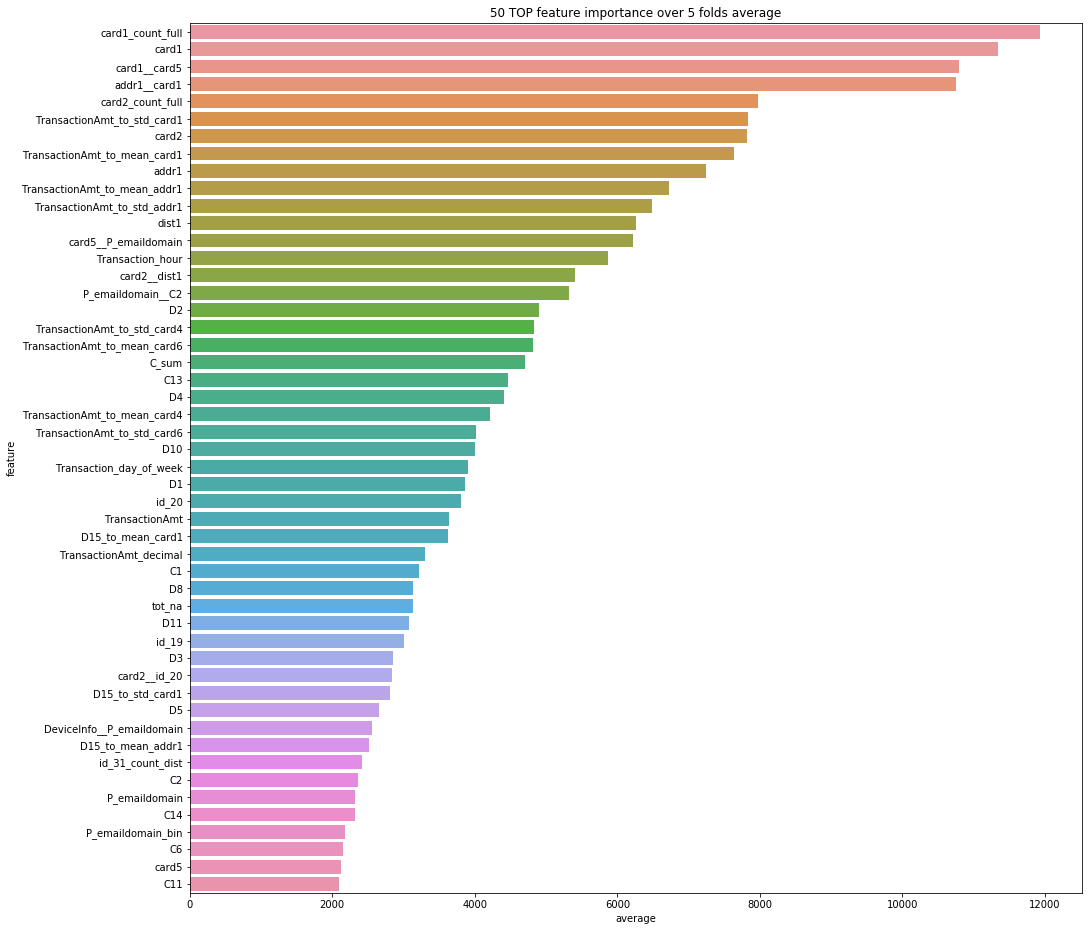

In [25]:
##take the mean of each feature importance of all folds. 
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

### Final submission - scored 0.945841 in public LB and 0.918956 in private LB 

In [ ]:

sub = pd.DataFrame(columns=['TransactionID','isFraud'])
sub['TransactionID'] = test_trans_id
sub['isFraud'] = y_result
sub

sub.to_csv("submission32rd.csv",index=False)

sum(y_result>0.1)
